In [1]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

n_inputs = t_u.shape[1]
n_outputs = t_c.shape[1]

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

In [3]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [4]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [5]:
from collections import OrderedDict

inpt = input("give number of hidden neurons: ")
n_outputs = int(inpt)

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, n_outputs)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(n_outputs, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=100, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=100, out_features=1, bias=True)
)

In [6]:
inpt = input("give learning rate: ")
learnrate = float(inpt)
optimizer = optim.SGD(seq_model.parameters(), lr=learnrate) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 219.1892, Validation loss 39.7832
Epoch 1000, Training loss 3.3921, Validation loss 1.9936
Epoch 2000, Training loss 2.8026, Validation loss 1.1565
Epoch 3000, Training loss 3.3120, Validation loss 0.9035
Epoch 4000, Training loss 2.9820, Validation loss 0.4742
Epoch 5000, Training loss 2.7625, Validation loss 0.2223
output tensor([[-4.3369],
        [ 8.6864]], grad_fn=<AddmmBackward0>)
answer tensor([[-4.],
        [ 8.]])
hidden tensor([[-5.1186e+00],
        [-7.6267e-03],
        [-1.6503e-02],
        [ 2.5135e-02],
        [ 1.9065e-03],
        [ 1.8569e-02],
        [ 6.7370e-02],
        [ 8.2513e+00],
        [ 6.9911e-03],
        [ 5.0315e-04],
        [-8.1636e+00],
        [-8.9524e-01],
        [-5.4637e+00],
        [ 6.5182e+00],
        [-3.6006e+00],
        [-2.6396e-02],
        [-6.8671e+00],
        [-2.7462e-03],
        [-5.7385e+00],
        [ 3.1066e-01],
        [ 1.4374e+00],
        [ 7.3647e+00],
        [ 2.4985e-03],
        [-2.

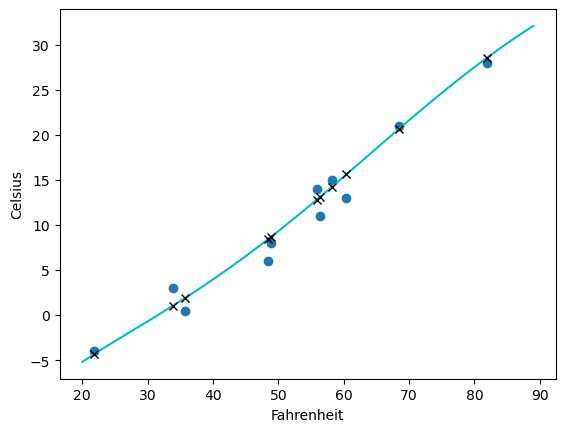

In [7]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
plt.show()

Bei dem Experimentieren mit der Erhögung der Anzahl der versteckten Neuronen fällt auf, dass bei gleichbleibender learning rate, ein optisch besseres Ergebnis und oftmals ein eher lineares Ausgangsverhalten erzeugt wird. Overfitting wird vor allem dann provoziert, wenn die learning rate erhöht wird. Wird die Anzahl der versteckten Neuronen auf eins gesetzt, so ähnelt das vorausgesagte Verhältnis der tanh Anktivierungsfunktion. Abschließend lässt sich festhalten, dass beide Parameter auf einander abgestimmt werdn müssen (Parametertuning), um ein Netz mit einem guten trainings loss und validation loss zu generiern. 